In [1]:
import pandas as pd
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [2]:
cn7 = pd.read_csv("../data/labeled_data.csv")
cn7 = cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD", "Reason", "Clamp_Open_Position",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])
cn7 = cn7[(cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G RH") | (cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G LH")]
cn7 = cn7.drop(columns=["PART_NAME"])
cn7 = cn7.replace("Y", 1).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23224\701848920.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7 = cn7.replace("Y", 1).replace("N", 0)


In [3]:
cn7_twelve = cn7.iloc[:,[0,1,4,5,6,7,10,12,17,19,20,21]]

In [4]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [5]:
cn7_pass = cn7_twelve[cn7_twelve["PassOrFail"] == 1]
cn7_fail = cn7_twelve[cn7_twelve["PassOrFail"] == 0]
cn7_pass_removed = cn7_pass.copy()
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Injection_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Cycle_Time')
cn7_removed = pd.concat([cn7_pass_removed, cn7_fail], ignore_index=True)


In [6]:
# cn7_removed

### 불량데이터를 양품의 70%정도로 증강

In [7]:
from sklearn.utils import resample

# 불량 데이터(클래스 0)와 양품 데이터(클래스 1) 분리
cn7_removed_negative = cn7_removed[cn7_removed['PassOrFail'] == 0]  # 불량 데이터
cn7_removed_positive = cn7_removed[cn7_removed['PassOrFail'] == 1]  # 양품 데이터

# 증강 전 클래스 분포 확인
before_cn7_removed_negative_count = len(cn7_removed_negative)
before_cn7_removed_positive_count = len(cn7_removed_positive)

print(f"증강 전 양품 데이터 개수: {before_cn7_removed_positive_count}")
print(f"증강 전 불량 데이터 개수: {before_cn7_removed_negative_count}")
print("============================")

# 목표 불량 데이터 개수 (양품 데이터의 70% 수준으로 설정)
target_defective_count = int(before_cn7_removed_positive_count * 0.7)

# 랜덤 오버샘플링 수행 (불량 데이터를 증강)
oversampled_negative_data = resample(
    cn7_removed_negative,
    replace=True,
    n_samples=target_defective_count,  # 목표 불량 데이터 개수로 증강
    random_state=42
)

# 증강된 불량 데이터와 기존 양품 데이터를 병합
oversample_data = pd.concat([cn7_removed_positive, oversampled_negative_data])

# 증강 후 클래스 분포 확인
augmented_defective_count = len(oversampled_negative_data)
augmented_non_defective_count = len(cn7_removed_positive)

print(f"증강 후 양품 데이터 개수: {augmented_non_defective_count}")
print(f"증강 후 불량 데이터 개수: {augmented_defective_count}")

증강 전 양품 데이터 개수: 6603
증강 전 불량 데이터 개수: 39
증강 후 양품 데이터 개수: 6603
증강 후 불량 데이터 개수: 4622


In [8]:
# 과하게 증강하면 과적합 나타날 수도 있음 ==> 양품의 70%만 증강

In [10]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("증강 전")
print(X_train.shape, y_train.shape)
print("====================================")
# 증강 전 클래스 분포 확인
before_cn7_removed_positive_count = len(cn7_removed_positive)

print(f"증강 전 양품 데이터 개수: {before_cn7_removed_positive_count}")
print(f"증강 전 불량 데이터 개수: {before_cn7_removed_negative_count}")
print("============================")

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"] > 250]

print(" Average_Screw_RPM 기준으로 up만 추출 한 후 ")
print(X_train.shape, y_train.shape)
print("====================================")

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]


# 목표 불량 데이터 개수 (양품 데이터의 70% 수준으로 설정)
target_defective_count = int(before_cn7_removed_positive_count * 0.7)

# 랜덤 오버샘플링 수행 (불량 데이터를 증강)
oversampled_negative_data = resample(
    cn7_removed_negative,
    replace=True,
    n_samples=target_defective_count,  # 목표 불량 데이터 개수로 증강
    random_state=42
)

# 증강된 불량 데이터와 기존 양품 데이터를 병합
oversampled_data = pd.concat([cn7_removed, oversampled_negative_data])

# 증강 후 데이터 분리
X_resampled = oversampled_data.drop(columns=["PassOrFail"])
y_resampled = oversampled_data["PassOrFail"]
# 증강 후 클래스 분포 확인
augmented_defective_count = len(oversampled_negative_data)
augmented_non_defective_count = len(cn7_removed_positive)

print(f"증강 후 양품 데이터 개수: {augmented_non_defective_count}")
print(f"증강 후 불량 데이터 개수: {augmented_defective_count}")


print("증강 후")
print(X_resampled.shape, y_resampled.shape)
print("====================================")



# 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("증강 후 검증데이터로 분리")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

# # 데이터 정규화
# ss=StandardScaler()
# ss.fit(X_train)
# X_train_scaled = ss.transform(X_train)
# X_val_scaled = ss.transform(X_val)
# X_test_scaled=ss.transform(X_test)

# # 모델 생성
# rf = RandomForestClassifier(random_state=42)
# et = ExtraTreesClassifier(random_state=42)
# gb = GradientBoostingClassifier(random_state=42)
# hgb = HistGradientBoostingClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42)
# model_list = [rf, et, gb, hgb, xgb]

# # GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
# for model in model_list:
#     model_name = model.__class__.__name__
#     gridParams = dict()
#     if model_name =="XGBClassifier" :
#         gridParams["n_estimators"] = [20,50]
#         gridParams["max_depth"] = [10,20]
#         gridParams["min_child_weight"] = [1, 2,4]
#     elif model_name == "HistGradientBoostingClassifier" :
#         gridParams["max_iter"] = [20, 50]
#         gridParams["max_depth"] = [10, 50]
#         gridParams["min_samples_leaf"] = [1,2,4]
#     else :
#         gridParams["n_estimators"] = [20, 50]
#         gridParams["max_depth"] = [10,20]
#         gridParams["min_samples_split"] = [2,5,10]
#         gridParams["min_samples_leaf"] = [1,2,4]

#     grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
#     grid_search_model.fit(X_train_scaled, y_train)
#     model = grid_search_model.best_estimator_
#     train_pred = model.predict(X_train_scaled)
#     val_pred = model.predict(X_val_scaled)
    
#     train_acc = accuracy_score(y_train, train_pred)
#     val_acc = accuracy_score(y_val, val_pred)
    
#     pre = precision_score(y_val, val_pred)
#     rec = recall_score(y_val, val_pred)
#     f1 = f1_score(y_val, val_pred)
    
#     pred = model.predict(X_test_scaled)
#     cm = confusion_matrix(y_test, pred)
#     TN = cm[0, 0]  # True Negative
#     FP = cm[0, 1]  # False Positive
#     FN = cm[1, 0]  # False Negative
#     TP = cm[1, 1]  # True Positive
    
#     df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
#                              columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

#     grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

# grid_df

증강 전
(4649, 11) (4649,)
증강 전 양품 데이터 개수: 6603
증강 전 불량 데이터 개수: 39
 Average_Screw_RPM 기준으로 up만 추출 한 후 
(4649, 11) (4649,)
증강 후 양품 데이터 개수: 6603
증강 후 불량 데이터 개수: 4622
증강 후
(11264, 11) (11264,)
증강 후 검증데이터로 분리
(7884, 11) (7884,)
(1993, 11) (1993,)
(3380, 11) (3380,)


In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, val_pred)
cm

NameError: name 'val_pred' is not defined

In [12]:
test_pred = model.predict(X_test_scaled)

test_acc = accuracy_score(y_test, test_pred)
test_pre = precision_score(y_test, test_pred)
test_rec = recall_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print(f"테스트 정확도: {test_acc}")
print(f"테스트 정밀도: {test_pre}")
print(f"테스트 재현율: {test_rec}")
print(f"테스트 f1-score: {test_f1}")

NameError: name 'model' is not defined

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_pred)
cm

NameError: name 'test_pred' is not defined

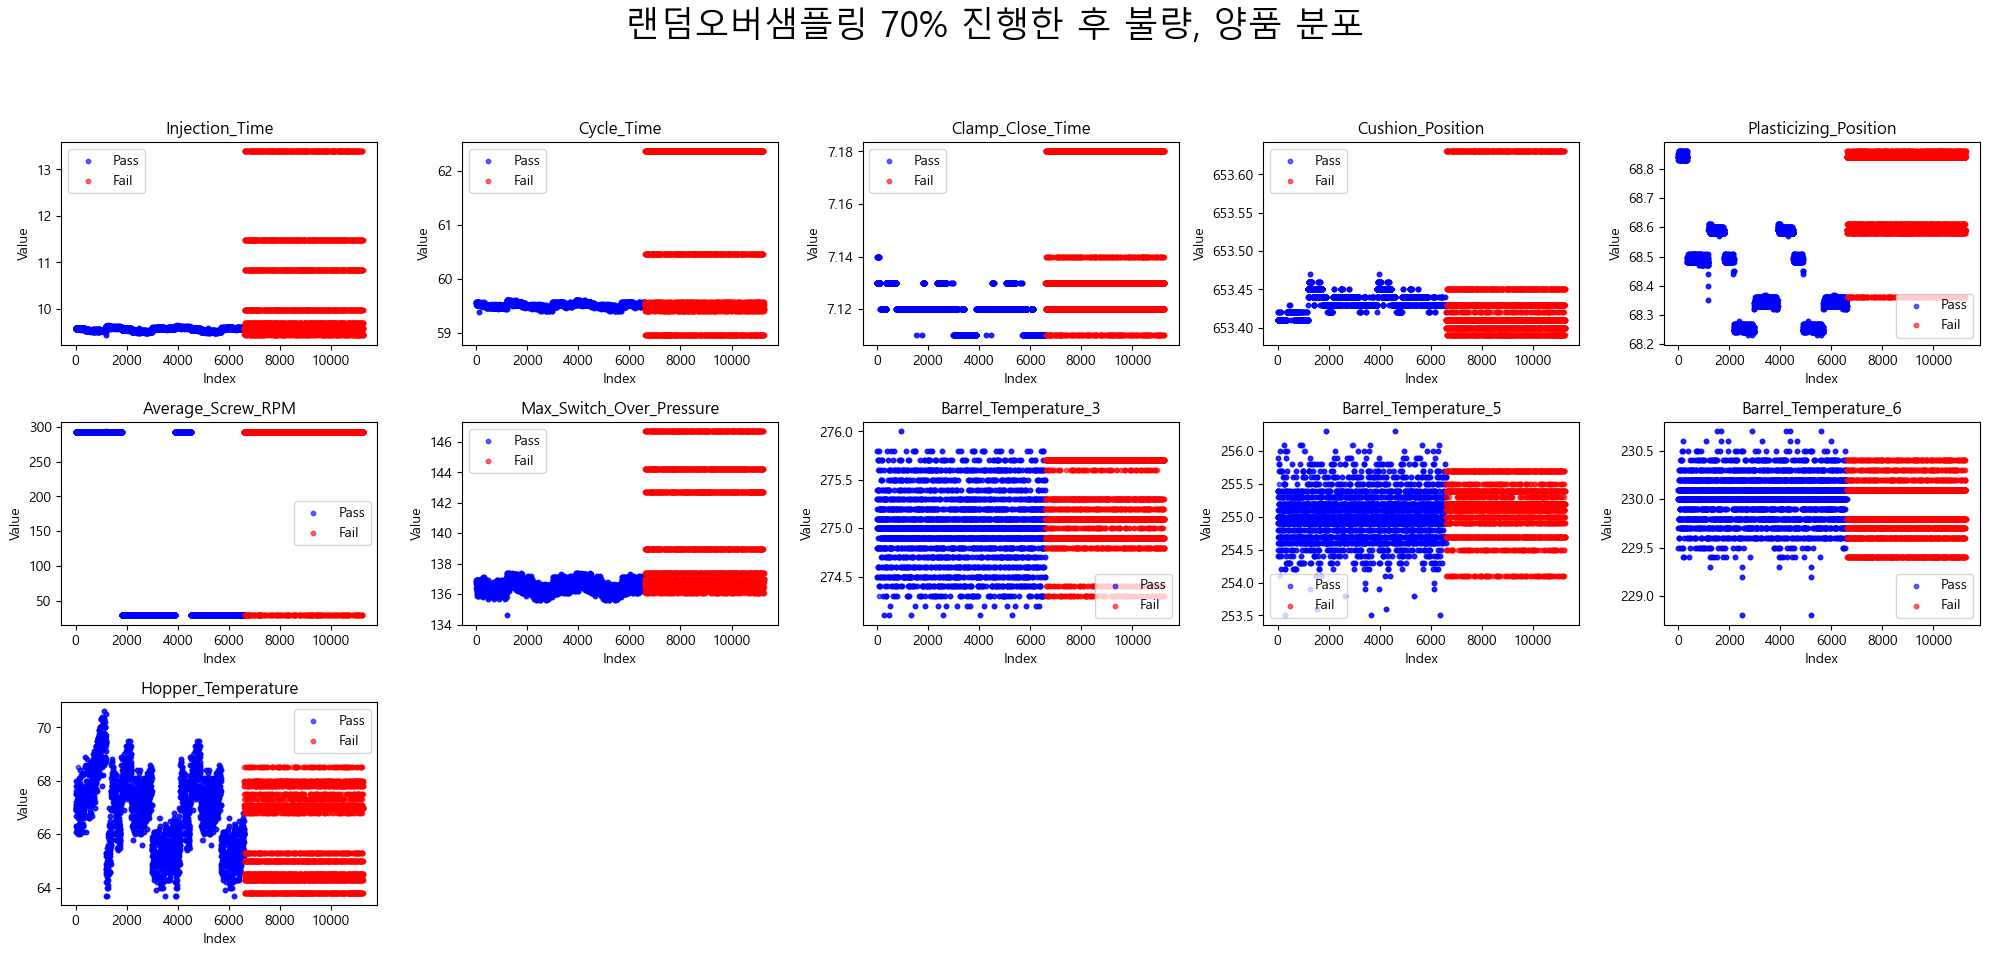

In [14]:
tmp_re = X_resampled.copy()
tmp_re["PassOrFail"] = y_resampled

# tmp_re와 y_resampled의 인덱스를 재설정
tmp_re.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("랜덤오버샘플링 70% 진행한 후 불량, 양품 분포", fontsize=25)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(tmp_re.index[y_resampled == 1], tmp_re[column][y_resampled == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(tmp_re.index[y_resampled == 0], tmp_re[column][y_resampled == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정 및 저장
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("랜덤70, 독립변수 11개.png", dpi=300)
plt.show()
